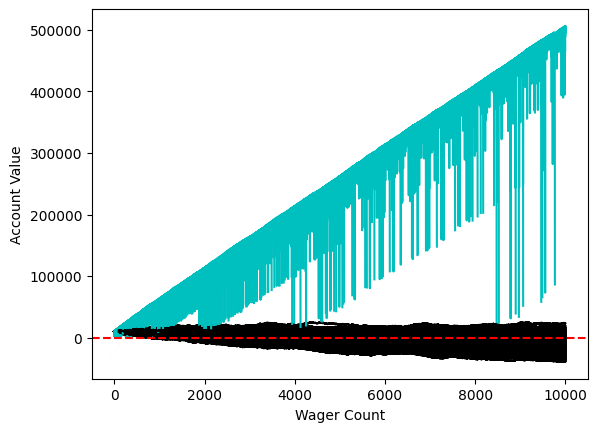

In [1]:
import random
import matplotlib.pyplot as plt
import matplotlib 
import time

sampleSize = 1000

startingFunds = 10000
wagerSize = 100
wagerCount = 10000
def roll_Dice():
    roll = random.randint(1, 100)
    if roll == 100:
        #print(roll, 'roll was 100, you lose. What are the odds?! Play Again!')
        return False
    elif roll <= 50:
        #print(roll, 'roll was 1-50, you lose. Play Again!')
        return False
    elif 100 > roll > 50:
        #print(roll, 'roll was 51-99, you win! *Lights flash* Play More!')
        return True

def doubler_bettor(funds, initial_wager, wager_count):
    value = funds
    wager = initial_wager
    global broke_count
    wX = []
    vY = []
    
    currentWager = 1
    previousWager = 'win'
    previousWagerAmount = initial_wager
    
    while currentWager <= wager_count:
        if previousWager == 'win':
            #print('we won the last wager, yay!')
            if roll_Dice():
                value += wager
                #print(value)
                wX.append(currentWager)
                vY.append(value)
            else:
                value -= wager
                previousWager = 'lose'
                #print(value)
                previousWagerAmount = wager
                wX.append(currentWager)
                vY.append(value)
                if value < 0:
                    #print('broke after', currentWager, 'wagers')
                    broke_count += 1
                    break
        elif previousWager == 'lose':
            #print('we lost the last wager, double up! Thats the smart play!')
            if roll_Dice():
                wager = previousWagerAmount * 2
                #print('we won',wager)
                value += wager
                #print(value)
                wager = initial_wager
                previousWager = 'win'
                wX.append(currentWager)
                vY.append(value)
            else:
                wager = previousWagerAmount * 2
                #print('we lost',wager)
                value -= wager
                if value < 0:
                    #print('broke after', currentWager, 'wagers')
                    broke_count += 1
                    break

                #print(value)
                previousWager = 'lose'
                
                previousWagerAmount = wager
                wX.append(currentWager)
                vY.append(value)    

        currentWager += 1
    #print(value)

    plt.plot(wX, vY,'c')




# xx = 0
# broke_count = 0

# while xx < 1000:
#     doubler_bettor(10000,100,100)
#     xx += 1

# print('death rate:', (broke_count/float(xx)) * 100)
# print('survival rate:', 100 - ((broke_count/float(xx)) * 100))

# plt.axhline(0, color = 'r')
# plt.show()









def simple_bettor(funds, initial_wager, wager_count):
    global broke_count
    value = funds
    wager = initial_wager
    
    wX = []
    vY = []
    
    currentWager = 1
    
    while currentWager <= wager_count:
        if roll_Dice():
            value += wager
            wX.append(currentWager)
            vY.append(value)
        else:
            value -= wager
            wX.append(currentWager)
            vY.append(value)

        currentWager += 1

    if value < 0:
        value = 'broke'
        broke_count += 1
    #print('Funds:', value)
    
    plt.plot(wX, vY,'k')

x = 0
broke_count = 0
while x < sampleSize:
    simple_bettor(startingFunds,wagerSize,wagerCount)
    doubler_bettor(startingFunds,wagerSize,wagerCount)
    x += 1

# print('death rate:', (broke_count/float(x)) * 100)
# print('survival rate:', 100 - ((broke_count/float(x)) * 100))


plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Wager Count')
plt.ylabel('Account Value')
plt.show()


    
        

